## Introduction



This tutorial shows the spectra generation for spin 0 and 2 fields with `pspy` and `NaMaster` and
compare results of both codes.



## Preamble



`matplotlib` magic



In [1]:
%matplotlib inline

Versions used for this tutorial



In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp
import pspy
import pymaster as nmt
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("    healpy :", hp.__version__)
print("      pspy :", pspy.__version__)
# print("  namaster :", nmt.__version__)

     Numpy : 1.18.1
Matplotlib : 3.1.2
    healpy : 1.13.0
      pspy : 1.0.0+130.g2de8443


We use the Planck colormap as default *via* `pixell`



In [3]:
from pixell import colorize
colorize.mpl_setdefault("planck")

## Generation of the template and mask



We start by specifying the `HEALPIX` survey parameters. It will be a disk of radius 25 degree centered
on longitude 30 degree and latitude 50 degree with a resolution `nside=512`.



In [4]:
lon, lat = 30, 50
radius = 25
nside = 512

For this example, we will make use of 3 components : Temperature (spin 0) and polarisation Q and U
(spin 2)



In [5]:
ncomp = 3

Given the parameters, we can generate the HEALPIX template as follow



In [6]:
from pspy import so_map
template_healpix = so_map.healpix_template(ncomp, nside=nside)

We also define a binary template for the window function: we set pixel inside the disk at 1 and pixel outside at zero



In [7]:
binary_healpix = so_map.healpix_template(ncomp=1, nside=nside)
vec = hp.pixelfunc.ang2vec(lon, lat, lonlat=True)
disc = hp.query_disc(nside, vec, radius=np.deg2rad(radius))
binary_healpix.data[disc] = 1

## Generation of spectra



### Generation of simulations



We first have to compute $C_\ell$ data using a cosmology code such as [CAMB](https://camb.readthedocs.io/en/latest/).



In [8]:
import camb
print("CAMB version:", camb.__version__)

CAMB version: 1.1.0


We will produce $C_\ell$ data from $\ell$<sub>min</sub>=2 to $\ell$<sub>max</sub>=10<sup>4</sup> for the following set
of $\Lambda$CDM parameters



In [9]:
lmin, lmax = 2, 10**4
l = np.arange(lmin, lmax)
cosmo_params = {
    "H0": 67.5,
    "As": 1e-10*np.exp(3.044),
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
pars = camb.set_params(**cosmo_params)
pars.set_for_lmax(lmax, lens_potential_accuracy=1)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

We finally have to write $C_\ell$ into a file to feed the `so_map.synfast` function for both
pixellisation templates



In [10]:
import os
output_dir = "/tmp/tutorial_pspy_namaster_spectra_spin0and2"
os.makedirs(output_dir, exist_ok=True)
cl_file = output_dir + "/cl_camb.dat"
np.savetxt(cl_file,
           np.hstack([l[:, np.newaxis], powers["total"][lmin:lmax]]))

Given the `CAMB` file, we generate a CMB realisation



In [11]:
cmb = template_healpix.synfast(cl_file)

on which we add white noise *i.e.* 20 µK.arcmin rms in temperature and 20xsqrt(2) µK.arcmin in
polarisation



In [12]:
noise = so_map.white_noise(cmb, rms_uKarcmin_T=20, rms_uKarcmin_pol=np.sqrt(2)*20)
cmb.data += noise.data

We can plot each component T, Q, U



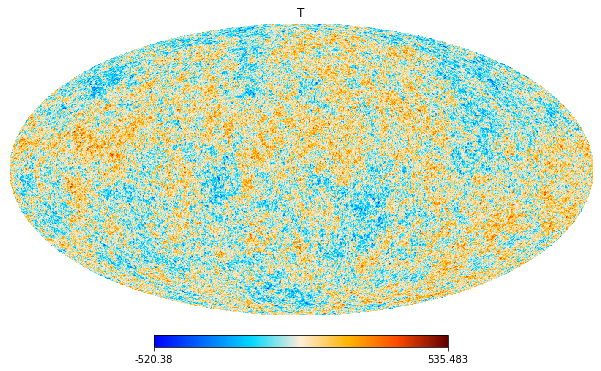

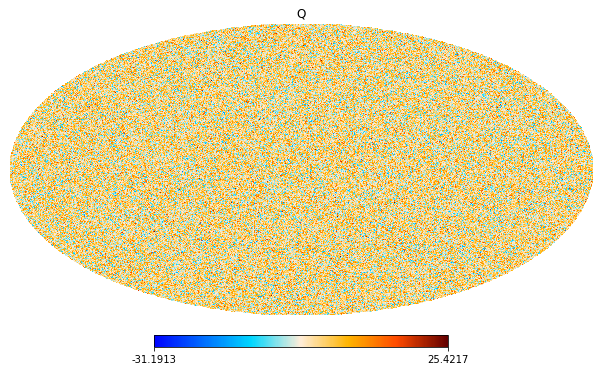

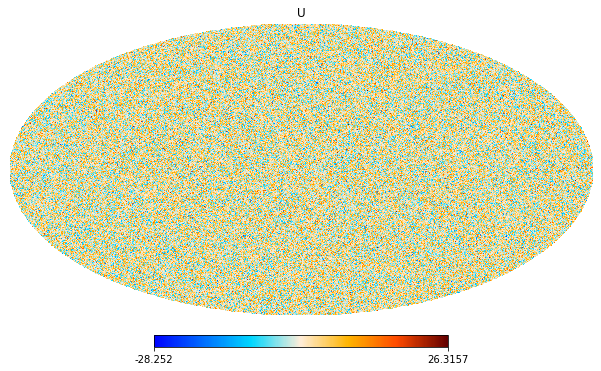

In [13]:
fields = ["T", "Q", "U"]
for i, field in enumerate(fields):
    hp.mollview(cmb.data[i], title="{}".format(field))

### Generate window



We then create an apodisation for the survey mask. We use a C1 apodisation with an apodisation size of 1 degree



In [14]:
from pspy import so_window
window = so_window.create_apodization(binary_healpix, apo_type="C1", apo_radius_degree=1)

We also create a point source mask made of 10 holes each with a 30 arcminutes size



In [15]:
mask = so_map.simulate_source_mask(binary_healpix, n_holes=10, hole_radius_arcmin=30)

and we apodize it



In [16]:
mask = so_window.create_apodization(mask, apo_type="C1", apo_radius_degree=1)

The window is given by the product of the survey window and the mask window



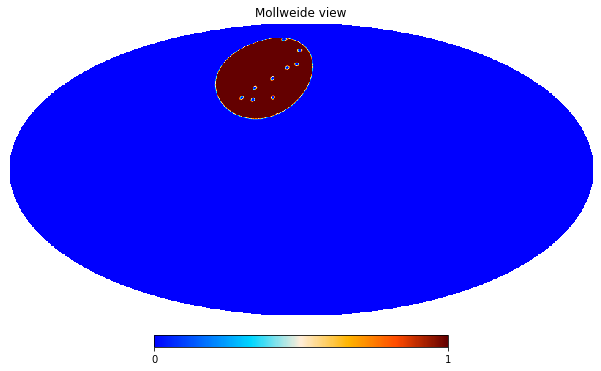

In [17]:
window.data *= mask.data
hp.mollview(window.data, min=0, max=1)

## Compute spin 0 and spin 2 spectra a la pspy



For spin 0 and 2 the window need to be a tuple made of two objects: the window used for spin 0 and the
one used for spin 2



In [18]:
window = (window, window)

We also set the number of iterations for the harmonic transform computation to 3



In [19]:
niter = 3

The windows (for `spin0` and `spin2`) are going to couple mode together, we compute a mode coupling
matrix in order to undo this effect given a binning file (format: lmin, lmax, lmean) and a
$\ell$<sub>max</sub> value corresponding to the maximum multiple to consider `3*nside-1`



In [20]:
lmax = 3 * nside -1
binning_file = output_dir + "/binning.dat"
from pspy import pspy_utils
pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)
from pspy import so_mcm
mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window, binning_file, lmax=lmax, type="Cl", niter=niter)

Compute alms and get binned and unbinned spectra



In [21]:
from pspy import sph_tools, so_spectra
alms = sph_tools.get_alms(cmb, window, niter=niter, lmax=lmax)
spectra = ["TT", "TE", "TB", "ET", "BT", "EE", "EB", "BE", "BB"]
ell, ps = so_spectra.get_spectra(alms, spectra=spectra)
lb_pspy, Clb_pspy = so_spectra.bin_spectra(ell, ps, binning_file, lmax, type="Cl", mbb_inv=mbb_inv, spectra=spectra)

## Compute spin 0 and spin 2 spectra a la NaMaster



We first define `NaMaster` fields corresponding to each spins



In [22]:
field_0 = nmt.NmtField(window[0].data, [cmb.data[0]])
field_2 = nmt.NmtField(window[1].data, [cmb.data[1], cmb.data[2]])

We also define the binning in $\ell$



In [23]:
nlb = 40
b = nmt.NmtBin(nside, nlb=nlb)
lb_namaster = b.get_effective_ells()

and the mode coupling matrices



In [24]:
wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field_0, field_2, b, is_teb=True,
                            n_iter=niter, lmax_mask=lmax)

Finally we compute the different spectra



In [1]:
# Compute mode-coupled Cls (for each pair of fields)
cl_coupled_00 = nmt.compute_coupled_cell(field_0, field_0)
cl_coupled_02 = nmt.compute_coupled_cell(field_0, field_2)
cl_coupled_22 = nmt.compute_coupled_cell(field_2, field_2)

# Bundle them up
cls_coupled = np.array([cl_coupled_00[0],  # TT
                        cl_coupled_02[0],  # TE
                        cl_coupled_02[1],  # TB
                        cl_coupled_22[0],  # EE
                        cl_coupled_22[1],  # EB
                        cl_coupled_22[2],  # BE
                        cl_coupled_22[3]])  # BB

# Invert MCM
cls_uncoupled = wsp.decouple_cell(cls_coupled)

Clb_namaster = {}
Clb_namaster["TT"] = cls_uncoupled[0]
Clb_namaster["TE"] = cls_uncoupled[1]
Clb_namaster["TB"] = cls_uncoupled[2]
Clb_namaster["ET"] = Clb_namaster["TE"]
Clb_namaster["BT"] = Clb_namaster["TB"]
Clb_namaster["EE"] = cls_uncoupled[3]
Clb_namaster["EB"] = cls_uncoupled[4]
Clb_namaster["BE"] = cls_uncoupled[5]
Clb_namaster["BB"] = cls_uncoupled[6]

NameError: name 'nmt' is not defined

## pspy vs. NaMaster : comparisons of spectra



We can compare spectra computations between both codes and show the relative deviation between
spectra



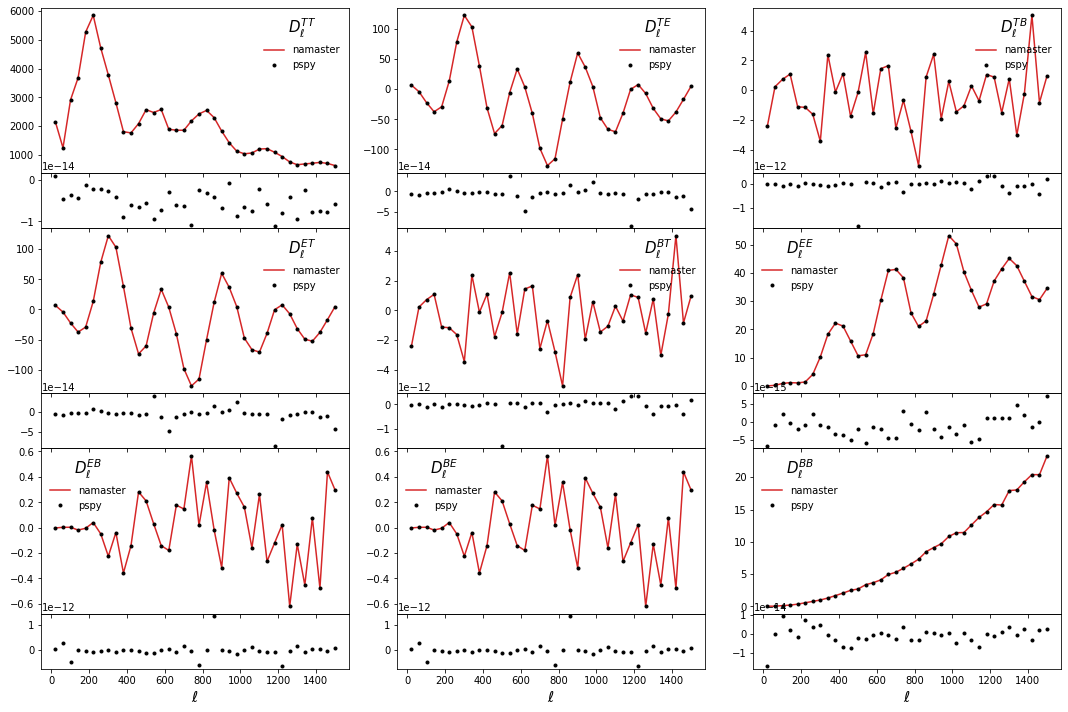

In [26]:
plt.figure(figsize=(15, 10))
grid = plt.GridSpec(3*4, 3, hspace=0)

for i, spec in enumerate(spectra):
    ix, iy = 4*(i // 3), i % 3
    main = plt.subplot(grid[ix:ix+3, iy], xticklabels=[])
    Dlb_namaster = Clb_namaster[spec]*lb_namaster**2/(2*np.pi)
    Dlb_pspy = Clb_pspy[spec]*lb_pspy**2/(2*np.pi)
    main.plot(lb_namaster, Dlb_namaster, "-", color="tab:red", label="namaster")
    main.plot(lb_pspy, Dlb_pspy, ".k", label="pspy")
    main.legend(title=r"$D^{%s}_{\ell}$" % spec, title_fontsize=15)

    # Relative deviation
    if ix != 8: # last
        dev = plt.subplot(grid[ix+3, iy], xticklabels=[])
    else:
        dev = plt.subplot(grid[ix+3, iy])
        dev.set_xlabel(r"$\ell$", fontsize=15)
    dev.plot(lb_pspy, (Clb_namaster[spec]-Clb_pspy[spec])/Clb_pspy[spec], ".k")
plt.tight_layout()

## Profiling pspy vs. NaMaster



We can profile the time execution of both codes and see if there is any difference. For such
purpose, we will first encapsulate each processing within dedicated functions



In [27]:
def run_pspy():
  lmax = 3 * nside -1
  binning_file = output_dir + "/binning.dat"
  pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)
  mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window,
                                              binning_file,
                                              lmax=lmax,
                                              type="Cl",
                                              niter=niter)
  alms = sph_tools.get_alms(cmb, window, niter=niter, lmax=lmax)
  ell, ps = so_spectra.get_spectra(alms, spectra=spectra)
  lb_pspy, Clb_pspy = so_spectra.bin_spectra(ell,
                                             ps,
                                             binning_file,
                                             lmax,
                                             type="Cl",
                                             mbb_inv=mbb_inv,
                                             spectra=spectra)

def run_namaster():
  nlb = 40
  b = nmt.NmtBin(nside, nlb=nlb)
  lb_namaster = b.get_effective_ells()
  wsp = nmt.NmtWorkspace()
  wsp.compute_coupling_matrix(field_0, field_2, b, is_teb=True,
                              n_iter=niter, lmax_mask=lmax)
  cl_coupled_00 = nmt.compute_coupled_cell(field_0, field_0)
  cl_coupled_02 = nmt.compute_coupled_cell(field_0, field_2)
  cl_coupled_22 = nmt.compute_coupled_cell(field_2, field_2)
  cls_coupled = np.array([cl_coupled_00[0],  # TT
                          cl_coupled_02[0],  # TE
                          cl_coupled_02[1],  # TB
                          cl_coupled_22[0],  # EE
                          cl_coupled_22[1],  # EB
                          cl_coupled_22[2],  # BE
                          cl_coupled_22[3]])  # BB
  cls_uncoupled = wsp.decouple_cell(cls_coupled)
  Clb_namaster = {k: cls_coupled[i] 
                  for i, k in enumerate(["TT", "TE", "TB", "EE", "EB", "BE", "BB"])}
  Clb_namaster["ET"] = Clb_namaster["TE"]
  Clb_namaster["BT"] = Clb_namaster["TB"]

We will use `line_profiler` package to get a line-by-line profile of each functions



In [28]:
%pip install line_profiler

Note: you may need to restart the kernel to use updated packages.


and we load the extension within this notebook



In [29]:
%load_ext line_profiler

We finally use the `%lprun` command to do a line-by-line profiling



In [30]:
%lprun -T /tmp/pspy_prof -f run_pspy run_pspy()
print(open("/tmp/pspy_prof", "r").read())


*** Profile printout saved to text file '/tmp/pspy_prof'. 
Timer unit: 1e-06 s

Total time: 22.5689 s
File: <ipython-input-27-e9277622e3ac>
Function: run_pspy at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_pspy():
     2         1          6.0      6.0      0.0    lmax = 3 * nside -1
     3         1          4.0      4.0      0.0    binning_file = output_dir + "/binning.dat"
     4         1       1799.0   1799.0      0.0    pspy_utils.create_binning_file(bin_size=40, n_bins=100, file_name=binning_file)
     5         2   16886817.0 8443408.5     74.8    mbb_inv, Bbl = so_mcm.mcm_and_bbl_spin0and2(window,
     6         1          1.0      1.0      0.0                                                binning_file,
     7         1          1.0      1.0      0.0                                                lmax=lmax,
     8         1          1.0      1.0      0.0                                       

In [31]:
%lprun -T /tmp/namaster_prof -f run_namaster run_namaster()
print(open("/tmp/namaster_prof", "r").read())


*** Profile printout saved to text file '/tmp/namaster_prof'. 
Timer unit: 1e-06 s

Total time: 44.9047 s
File: <ipython-input-27-e9277622e3ac>
Function: run_namaster at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           def run_namaster():
    21         1          3.0      3.0      0.0    nlb = 40
    22         1        114.0    114.0      0.0    b = nmt.NmtBin(nside, nlb=nlb)
    23         1         32.0     32.0      0.0    lb_namaster = b.get_effective_ells()
    24         1          8.0      8.0      0.0    wsp = nmt.NmtWorkspace()
    25         2   44745972.0 22372986.0     99.6    wsp.compute_coupling_matrix(field_0, field_2, b, is_teb=True,
    26         1          2.0      2.0      0.0                                n_iter=niter, lmax_mask=lmax)
    27         1      23803.0  23803.0      0.1    cl_coupled_00 = nmt.compute_coupled_cell(field_0, field_0)
    28         1      49313.0  49313.0      0.1 